In [1]:
import numpy as np
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from keras.regularizers import L1L2
from tf2crf import CRF


import keras.backend as K
import pandas as pd
import pickle

c:\Users\Egor\Anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
total_size = 100_000
file_n = total_size // 1000

In [3]:
y = []

with open('data/all/y_all.pickle', 'rb') as f:
    y = pickle.load(f)

y = [y1+1 for y1 in y]

y = tf.keras.utils.pad_sequences(y, maxlen=100, padding='post', value=0, dtype=np.uint8)

In [4]:
DATA_DIR = r'D:\VKR_data\data\x_bert_emb'
FILE_LIST_ALL = np.array(os.listdir(DATA_DIR))
FILE_LIST = np.hstack((FILE_LIST_ALL[:file_n//2], FILE_LIST_ALL[file_n//2:]))

In [5]:
# Перемешиваем так, чтобы в выборках оказалось равное кол-во экземпляров каждого датасета
shuffled_idx = []
idx_1 = np.random.RandomState(seed=33).permutation(file_n//2)
idx_2 = np.random.RandomState(seed=33).permutation(np.arange(file_n//2, file_n))

for i in range(file_n//2):
    shuffled_idx.extend([idx_1[i], idx_2[i]])
shuffled_idx = np.array(shuffled_idx)

In [6]:
y_shuffled = []
for idx in shuffled_idx:
    y_shuffled.extend(y[idx*1000:idx*1000+1000])

In [7]:
def load_file(filepath):
    with open(filepath, 'rb') as f:
        data = np.load(f)
    return data
    
def data_gen():
    i = 0
    for filename in FILE_LIST[shuffled_idx]:
        data = load_file(DATA_DIR+'/'+filename)
        for x in data:
            yield x, y_shuffled[i]
            i += 1

In [8]:
BATCH_SIZE = 400

dataset = tf.data.Dataset.from_generator(
    data_gen,
    output_signature=(
        tf.TensorSpec(shape=(100, 768,), dtype=tf.float32),
        tf.TensorSpec(shape=(100,), dtype=tf.int8)),
).batch(BATCH_SIZE)

In [9]:
TRAIN_STEPS = int(total_size * 0.8) // BATCH_SIZE
TEST_STEPS  = int(total_size * 0.2) // BATCH_SIZE

train_ds = dataset.take(TRAIN_STEPS).repeat().prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(TRAIN_STEPS).take(TEST_STEPS).repeat().prefetch(tf.data.AUTOTUNE)

In [11]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, maxlen=100, embed_dim=768
    ):
        super().__init__()
        self.bilstm = Bidirectional(LSTM(units=embed_dim, return_sequences=True,),
                                    input_shape=(maxlen, embed_dim,))
        self.dropout1 = Dropout(0.3)
        self.lstm =LSTM(units=embed_dim, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.00))
        self.dropout2 = Dropout(0.3)
        self.dense = TimeDistributed(Dense(512, activation="relu", kernel_regularizer=L1L2(l1=0.01, l2=0.00)))
        self.dropout3 = Dropout(0.5)
        self.crf = CRF(num_tags)

    def call(self, inputs, training=False):
        x = self.bilstm(inputs)
        x = self.dropout1(x)
        x = self.lstm(x)
        x = self.dropout2(x)
        x = self.dense(x)
        x = self.dropout3(x)
        x = self.crf(x)
        
        return x

In [12]:
from tensorflow_addons.text.crf import crf_log_likelihood

def unpack_data(data):
    if len(data) == 2:
        return data[0], data[1], None
    elif len(data) == 3:
        return data
    else:
        raise TypeError("Expected data to be a tuple of size 2 or 3.")

class ModelWithCRFLoss(tf.keras.Model):

    def __init__(self, base_model, sparse_target=True, metrics_fn=tf.keras.metrics.Accuracy(name='accuracy')):
        super().__init__()
        self.base_model = base_model
        self.model_layers = [layer for layer in self.base_model.layers]
        self.sparse_target = sparse_target
        self.metrics_fn = metrics_fn
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    def call(self, inputs, training=False):
        output = inputs
        for layer in self.model_layers:
            output = layer(output)
        if training:
            return output
        else:
            return output[0]

    def compute_loss(self, x, y, training=False):
        viterbi_sequence, potentials, sequence_length, chain_kernel = self(x, training=training)
        # we now add the CRF loss:
        crf_loss = -crf_log_likelihood(potentials, y, sequence_length, chain_kernel)[0]
        return viterbi_sequence, sequence_length, tf.reduce_mean(crf_loss)

    def train_step(self, data):
        x, y, sample_weight = unpack_data(data)
        # y : '(batch_size, seq_length)'
        if self.sparse_target:
            assert len(y.shape) == 2
        else:
            y = tf.argmax(y, axis=-1)
        with tf.GradientTape() as tape:
            viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, training=True)
            loss = crf_loss + tf.cast(tf.reduce_sum(self.losses), crf_loss.dtype)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.metrics_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return {"loss": self.loss_tracker.result(), self.metrics_fn.name: self.metrics_fn.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.metrics_fn]

    def test_step(self, data):
        x, y, sample_weight = unpack_data(data)
        # y : '(batch_size, seq_length)'
        if self.sparse_target:
            assert len(y.shape) == 2
        else:
            y = tf.argmax(y, axis=-1)
        viterbi_sequence, sequence_length, crf_loss = self.compute_loss(x, y, training=True)
        loss = crf_loss + tf.cast(tf.reduce_sum(self.losses), crf_loss.dtype)
        self.loss_tracker.update_state(loss)
        self.metrics_fn.update_state(y, viterbi_sequence, tf.sequence_mask(sequence_length, y.shape[1]))
        return {"loss": self.loss_tracker.result(), f'{self.metrics_fn.name}': self.metrics_fn.result()}

In [13]:
class MacroF1(keras.metrics.Metric):

  def __init__(self, n_tags, name='macro_f1', **kwargs):
    super().__init__(name=name, **kwargs)
    self.n_tags=n_tags
    self.macro_f = self.add_weight(name='macro_f1', initializer='zeros')

  def recall_m(self, y_true, y_pred):
        TP = K.sum(K.round(y_true * y_pred))
        Positives = K.sum(K.round(y_true))

        recall = TP / (Positives+K.epsilon())
        return recall

  def precision_m(self, y_true, y_pred):
      TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

      precision = TP / (Pred_Positives+K.epsilon())
      return precision

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.one_hot(tf.cast(y_true, 'uint8'), depth=self.n_tags)
    y_pred = tf.one_hot(tf.cast(y_pred, 'uint8'), depth=self.n_tags)

    f_classes = []
    for i in range(self.n_tags):   # Считаем f_score для каждого класса и усредняем
        y_t = y_true[:, :, i]
        y_p = y_pred[:, :, i]
        precision, recall = self.precision_m(y_t, y_p), self.recall_m(y_t, y_p)
        f = 2*((precision*recall)/(precision+recall+K.epsilon()))
        f_classes.append(f)
    self.macro_f = tf.math.reduce_mean(f_classes)

  def result(self):
    return self.macro_f

  def reset_state(self):
    self.macro_f = tf.zeros([1])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
checkpoint = ModelCheckpoint('./checkpoints/bert_bilstm_crf/best', monitor='val_macro_f1', mode='max',
                                                save_best_only=True, save_weights_only=True)

stop_early = EarlyStopping(monitor='val_macro_f1', mode='max', patience=8)

In [16]:
macro_f1 = MacroF1(n_tags = 8)

ner_model = ModelWithCRFLoss(NERModel(num_tags=8), metrics_fn=macro_f1)
ner_model.compile(optimizer="adam")

In [17]:
model_history = ner_model.fit(train_ds, epochs=80,
                validation_data=test_ds,
                steps_per_epoch=TRAIN_STEPS,
                validation_steps=TEST_STEPS,
                callbacks = [checkpoint, stop_early])

Epoch 1/80
200/200 [==============================] - 152s 717ms/step - loss: 13.0990 - macro_f1: 0.3789 - val_loss: 7.0683 - val_macro_f1: 0.3571
Epoch 2/80
200/200 [==============================] - 141s 708ms/step - loss: 5.9368 - macro_f1: 0.5860 - val_loss: 5.1290 - val_macro_f1: 0.5825
Epoch 3/80
200/200 [==============================] - 142s 709ms/step - loss: 4.4241 - macro_f1: 0.6325 - val_loss: 4.1604 - val_macro_f1: 0.6607
Epoch 4/80
200/200 [==============================] - 141s 706ms/step - loss: 3.7756 - macro_f1: 0.7071 - val_loss: 3.4428 - val_macro_f1: 0.6908
Epoch 5/80
200/200 [==============================] - 147s 739ms/step - loss: 3.0795 - macro_f1: 0.7767 - val_loss: 3.1130 - val_macro_f1: 0.7177
Epoch 6/80
200/200 [==============================] - 149s 748ms/step - loss: 2.6759 - macro_f1: 0.7892 - val_loss: 2.8167 - val_macro_f1: 0.7452
Epoch 7/80
200/200 [==============================] - 147s 734ms/step - loss: 2.3329 - macro_f1: 0.8107 - val_loss: 2.7527 

In [18]:
ner_model.load_weights('./checkpoints/bert_bilstm_crf/best')
# ner_model.save_weights('./models/bert_bilstm_crf/bert_bilstm_crf')

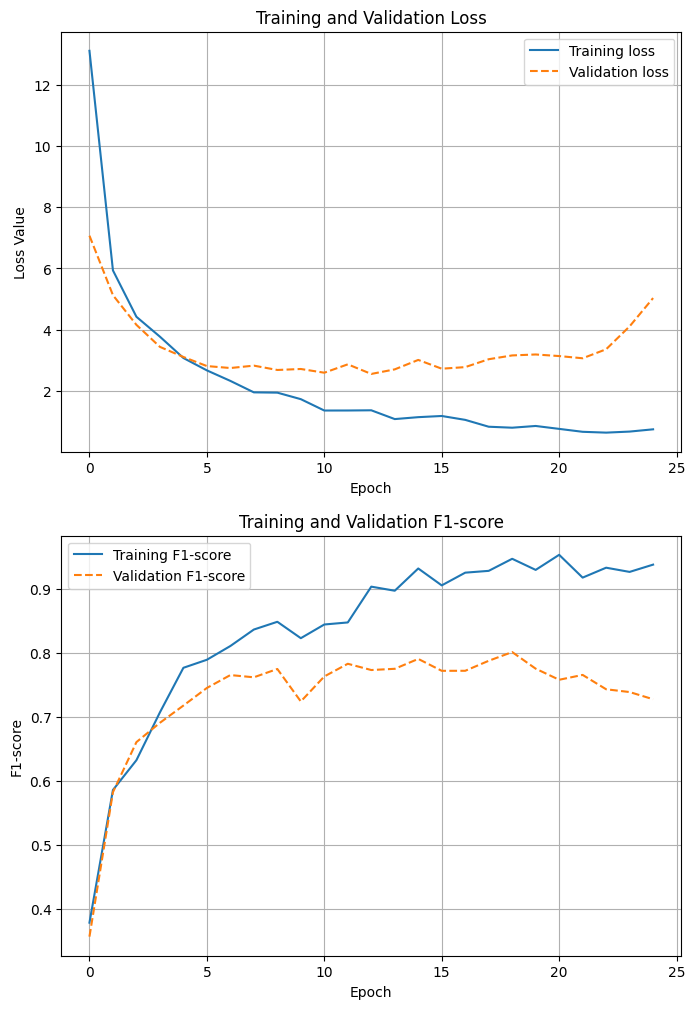

In [19]:
loss = model_history.history['loss'][:-2]
val_loss = model_history.history['val_loss'][:-2]

f1 = model_history.history['macro_f1'][:-2]
val_f1 = model_history.history['val_macro_f1'][:-2]

plt.figure(figsize=(8,12))
plt.subplot(211)
plt.plot(model_history.epoch[:-2], loss, '-', label='Training loss')
plt.plot(model_history.epoch[:-2], val_loss, '--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.grid()
plt.legend()

plt.subplot(212)
plt.plot(model_history.epoch[:-2], f1, '-', label='Training F1-score')
plt.plot(model_history.epoch[:-2], val_f1, '--', label='Validation F1-score')
plt.title('Training and Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.show()

In [37]:
# ner_model.load_weights('./models/bert_bilstm_crf')

In [24]:
def multiclass_accuracy(y_pred, y_true):
    return np.mean(np.equal(y_true, y_pred))

y_test_pred = ner_model.predict(load_file(DATA_DIR+'/'+FILE_LIST[-1]))

y_test = y[-1000:]
test_accuracy = multiclass_accuracy(y_test_pred, y_test)

print(test_accuracy)

32/32 [==============================] - 5s 117ms/step
0.99667


In [18]:
# from sklearn.metrics import classification_report

In [20]:
tags_inv = {
    0: '[PAD]',
    1: 'O',
    2: 'B-PER',
    3: 'I-PER',
    4: 'B-ORG',
    5: 'I-ORG',
    6: 'B-LOC',
    7: 'I-LOC'
}

tag_names = list(tags_inv.values())

In [26]:
elmo = hub.load(r'C:\Users\Egor\Desktop\python\VKR\elmo_ru-news_wmt11-16_1.5M_steps')

In [27]:
def check_on_sentence(sentences):
    ls = [len(s) for s in sentences]
    emb = tf.keras.utils.pad_sequences(sentences, maxlen=100, padding='post', value='', dtype=object)
    emb = elmo.signatures['tokens'](tokens=tf.cast(emb, tf.string), sequence_len = tf.cast(ls, tf.int32))['elmo']
    tags = ner_model.predict(emb)
    out = []
    for i in range(len(ls)):
        out.append([sentences[i], tags[i][:ls[i]]])       
    tf.keras.backend.clear_session()
    return out

In [28]:
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer
from tabulate import tabulate

In [58]:
text = '''\
Пожалуйста, предоставьте Михаилу Ивановичу Резниченко офис по адресу г. Москва, улица Орджоникидзе, дом 11.
Генеральный директор оператора "Северного потока - 2" - компании Nord Stream 2 AG - Маттиас Варниг в конце марта покинет пост главы компании, говорится в сообщении оператора.
'''

In [29]:
def print_tags(data):
    tokens, tags = data
    t_inv = [tags_inv[t] for t in tags]
    print(tabulate(zip(tokens, t_inv)))

In [30]:
def tokenize_text(text):
    s_t = sent_tokenize(text)
    return [WordPunctTokenizer().tokenize(s) for s in s_t]

def text_to_predict(text):
    tok = tokenize_text(text)
    for sent in check_on_sentence(tok):
        print_tags(sent)

In [59]:
text_to_predict(text)

1/1 [==============================] - 0s 374ms/step
------------  -----
Пожалуйста    O
,             O
предоставьте  O
Михаилу       B-PER
Ивановичу     I-PER
Резниченко    I-PER
офис          O
по            O
адресу        O
г             O
.             O
Москва        B-LOC
,             O
улица         O
Орджоникидзе  B-LOC
,             O
дом           O
11            O
.             O
------------  -----
-----------  -----
Генеральный  O
директор     O
оператора    O
"            O
Северного    O
потока       O
-            O
2            O
"            O
-            O
компании     O
Nord         B-ORG
Stream       I-ORG
2            I-ORG
AG           I-ORG
-            O
Маттиас      B-PER
Варниг       I-PER
в            O
конце        O
марта        O
покинет      O
пост         O
главы        O
компании     O
,            O
говорится    O
в            O
сообщении    O
оператора    O
.            O
-----------  -----


In [21]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [22]:
# y_pred = ner_model.predict(load_file(DATA_DIR+'/'+FILE_LIST[-1]))
y_pred = ner_model.predict(test_ds, steps=TEST_STEPS, verbose=1)
# y_pred = np.argmax(y_pred, axis=-1)

50/50 [==============================] - 43s 194ms/step


In [23]:
y_test = np.array(y_shuffled[-TEST_STEPS*BATCH_SIZE:])

In [24]:
print(classification_report(y_test.flatten(), y_pred.flatten(), labels=[1,2,3,4,5,6,7], digits=4,
                            target_names = tag_names[1:]))

              precision    recall  f1-score   support

           O     0.9720    0.9849    0.9785    324966
       B-PER     0.8314    0.8245    0.8280      6724
       I-PER     0.8667    0.8374    0.8518      5425
       B-ORG     0.7559    0.7058    0.7300      5310
       I-ORG     0.7762    0.6544    0.7101      4022
       B-LOC     0.7926    0.7991    0.7958     11450
       I-LOC     0.7682    0.5662    0.6519      3043

   micro avg     0.9562    0.9625    0.9594    360940
   macro avg     0.8233    0.7675    0.7923    360940
weighted avg     0.9551    0.9625    0.9586    360940



<Axes: >

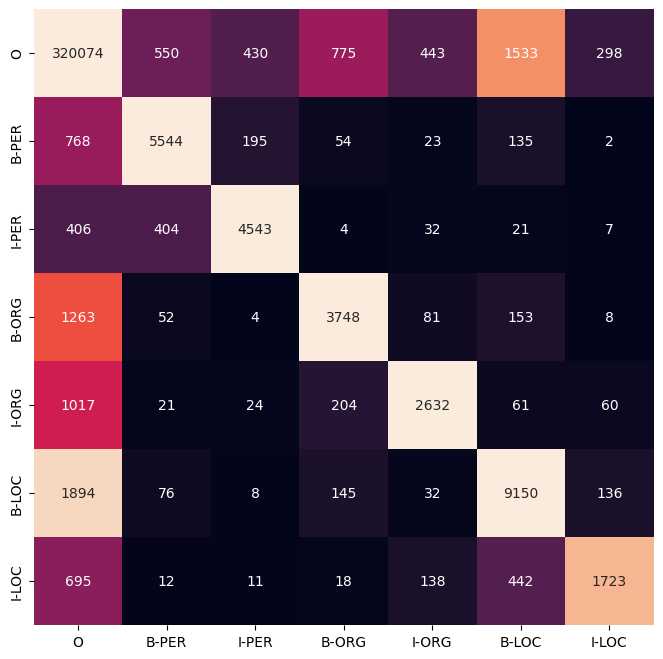

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test.flatten(), y_pred.flatten(), labels=[1,2,3,4,5,6,7]),
            annot=True, fmt='d', xticklabels=tag_names[1:], yticklabels=tag_names[1:], vmax=2000, cbar=False)